# 02 — Preprocessing & Stationarity (ADF, KPSS, PP)

Covers resampling, transformations, differencing, and unit root tests (ADF, KPSS, Phillips–Perron).


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
# Re-create the synthetic series
idx = pd.date_range("2015-01-01", periods=120, freq="MS")
trend = np.linspace(50, 150, len(idx))
seasonal = 10*np.sin(2*np.pi*idx.month/12)
rng = np.random.default_rng(0)
noise = rng.normal(0, 3, len(idx))
ts = pd.Series(trend + seasonal + noise, index=idx, name="value")

In [3]:
# Resample demo: convert to quarterly mean
ts_q = ts.resample("QS").mean()
ts_q.head()


,value
2015-01-01,59.361135
2015-04-01,57.845588
2015-07-01,49.542947
2015-10-01,52.002573
2016-01-01,65.021388


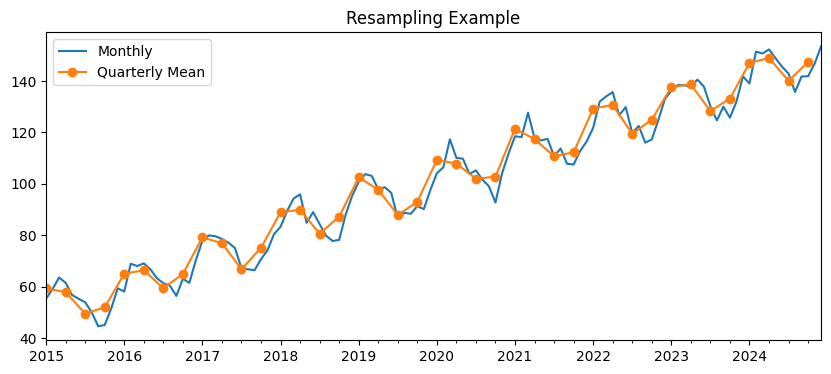

In [4]:

# Visualize resampled series
plt.figure(figsize=(10,4))
ts.plot(label="Monthly")
ts_q.plot(marker="o", label="Quarterly Mean")
plt.title("Resampling Example")
plt.legend(); plt.show()


In [5]:
# Variance stabilization: log (add a positive shift to avoid log(<=0))
ts_log = np.log(ts - ts.min() + 1)

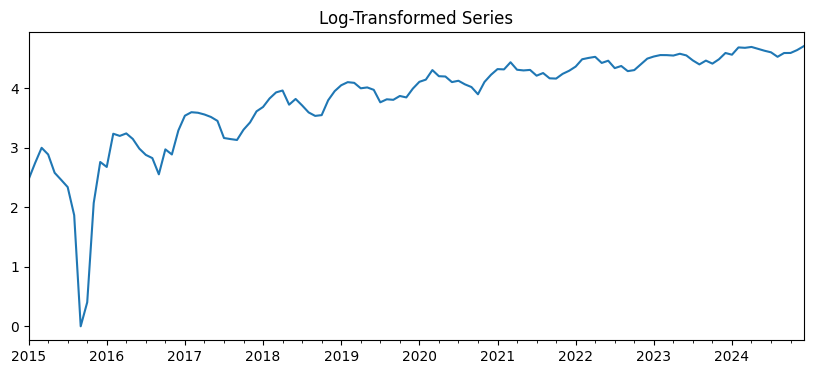

In [6]:
plt.figure(figsize=(10,4))
ts_log.plot()
plt.title("Log-Transformed Series")
plt.show()


In [7]:
# Differencing to remove trend/seasonality
diff1 = ts.diff().dropna()
seas_diff = ts.diff(12).dropna()


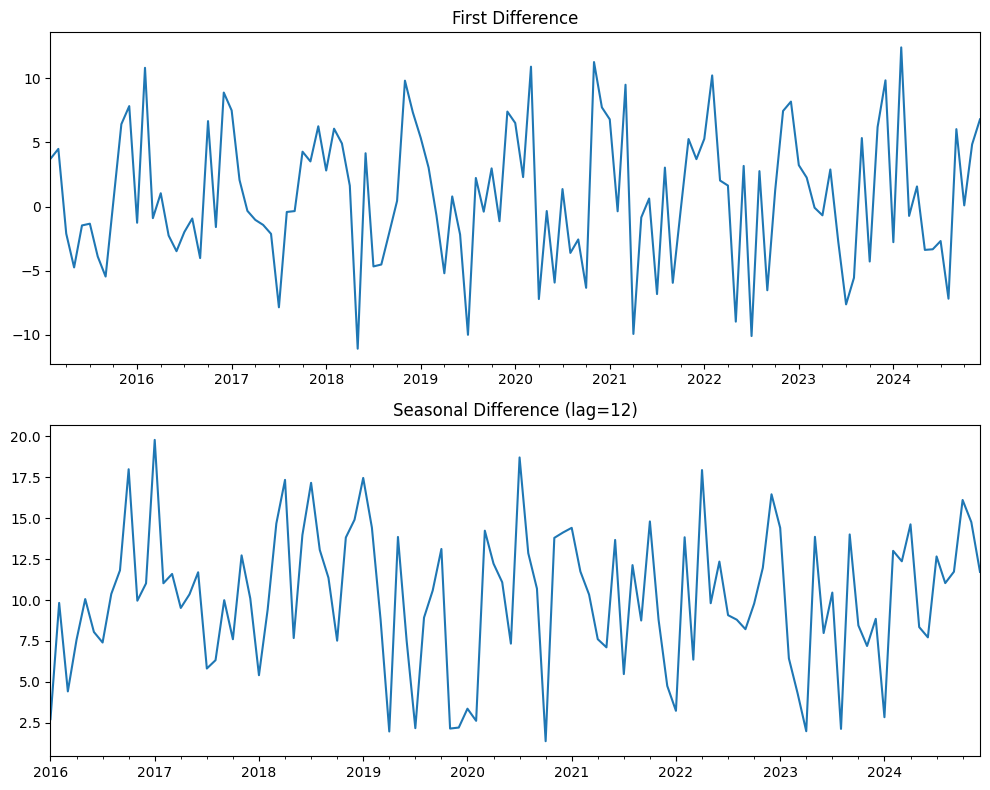

In [8]:
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
diff1.plot()
plt.title("First Difference")

plt.subplot(2,1,2)
seas_diff.plot()
plt.title("Seasonal Difference (lag=12)")
plt.tight_layout(); plt.show()


In [9]:
def adf_test(x):
    res = adfuller(x, autolag="AIC")
    return {"stat": res[0], "p": res[1], "lags": res[2], "nobs": res[3]}

In [10]:
def kpss_test(x):
    # Regression='c' (level) is default
    stat, p, lags, crit = kpss(x, nlags="auto")
    return {"stat": stat, "p": p, "lags": lags}

In [11]:
tests = {
    "original": (adf_test(ts), kpss_test(ts)),
    "first_diff": (adf_test(diff1), kpss_test(diff1)),
    "seasonal_diff": (adf_test(seas_diff), kpss_test(seas_diff)),
}

/tmp/ipython-input-2170345433.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(x, nlags="auto")
/tmp/ipython-input-2170345433.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(x, nlags="auto")
/tmp/ipython-input-2170345433.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(x, nlags="auto")


In [17]:
tests

{'original': ({'stat': np.float64(0.043123273570681867),
   'p': np.float64(0.9619563412392514),
   'lags': 11,
   'nobs': 108},
  {'stat': np.float64(1.775675658270642), 'p': np.float64(0.01), 'lags': 6}),
 'first_diff': ({'stat': np.float64(-7.912398882083522),
   'p': np.float64(3.916273872770289e-12),
   'lags': 10,
   'nobs': 108},
  {'stat': np.float64(0.016526939655673045), 'p': np.float64(0.1), 'lags': 4}),
 'seasonal_diff': ({'stat': np.float64(-3.627048339828492),
   'p': np.float64(0.005264485565907674),
   'lags': 13,
   'nobs': 94},
  {'stat': np.float64(0.0535644361681555), 'p': np.float64(0.1), 'lags': 2})}

* **ADF (Augmented Dickey–Fuller):**

  * **H₀:** Unit root (series is **non-stationary**).
  * Small *p* (<0.05) → reject H₀ → stationary.

* **KPSS (Kwiatkowski–Phillips–Schmidt–Shin):**

  * **H₀:** Series is **stationary**.
  * Small *p* (<0.05) → reject H₀ → non-stationary.

Using both together gives a clearer picture.

---

### 🔹 obtained results

1. **Original Series**

   * **ADF:** stat ≈ 0.04, *p* ≈ 0.96 → **fail to reject H₀ → non-stationary**
   * **KPSS:** stat ≈ 1.77, *p* = 0.01 → reject H₀ → **non-stationary**
     👉 Both tests agree: the original series is **non-stationary**.

---

2. **First Difference**

   * **ADF:** stat ≈ -7.91, *p* ≈ 3.9e-12 → reject H₀ → **stationary**
   * **KPSS:** stat ≈ 0.0165, *p* = 0.1 → fail to reject H₀ → **stationary**
     👉 Both agree: **first differencing makes the series stationary**.

---

3. **Seasonal Difference (lag=12)**

   * **ADF:** stat ≈ -3.63, *p* ≈ 0.005 → reject H₀ → **stationary**
   * **KPSS:** stat ≈ 0.053, *p* = 0.1 → fail to reject H₀ → **stationary**
     👉 Both agree: **seasonal differencing also makes the series stationary**.

---

### 🔹 Conclusion

* **Original series:** Non-stationary
* **After first differencing:** Stationary
* **After seasonal differencing:** Stationary

